In [1]:
from pathlib import Path
from functools import partial

import torch
from torch.nn.functional import softmax
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import seaborn as sns

from ballchallenge.model import BallChallengeModel
from ballchallenge.accelerometer_dataset import AccelerometerDataset
from ballchallenge.training import run_training
from elasticai.creator.file_generation.on_disk_path import OnDiskPath
from elasticai.creator.vhdl.system_integrations.firmware_env5 import FirmwareENv5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = Path("../data")
GRID_SIZE = (10, 10)

In [2]:
def flat_labels(labels: torch.Tensor) -> torch.Tensor:
    return labels.flatten(start_dim=1)

def downsample(samples: torch.Tensor, factor: int) -> torch.Tensor:
    return samples[:,:,::factor]

def downsample_and_substract_mean(samples: torch.Tensor, factor):
    return samples[:,:, ::factor] - samples[:, :, ::factor].mean(dim=2, keepdim=True)

downsampling_factor = 4

ds = AccelerometerDataset(
    dataset_root=DATASET_ROOT,
    grid_size=GRID_SIZE,
    x_position_range=(0, 2),
    y_position_range=(0, 2),
    label_std=0.24,
    transform_samples=partial(downsample_and_substract_mean, factor=downsampling_factor),
    transform_labels=flat_labels,
)
ds_train, ds_test = random_split(ds, lengths=[0.75, 0.25])

print("Train Samples:", ds_train[:][0].shape)
print("Test Samples:", ds_test[:][0].shape)

RuntimeError: The size of tensor a (250) must match the size of tensor b (3) at non-singleton dimension 2

In [ ]:
model = BallChallengeModel(total_bits=16, frac_bits=8, signal_length=ds_train[0][0].shape[1], grid_size=GRID_SIZE)

sum(param.numel() for param in model.parameters())

5055

In [ ]:
history = run_training(
    model=model,
    ds_train=ds_train,
    ds_test=ds_test,
    batch_size=8,
    epochs=800,
    learning_rate=1e-4,
    device=DEVICE
)

model.eval()
model.to("cpu")

[epoch 1/800] train_loss: 0.2437 ; train_accuracy: 0.0000 ; test_loss: 0.2493 ; test_accuracy: 0.0000
[epoch 2/800] train_loss: 0.2436 ; train_accuracy: 0.0000 ; test_loss: 0.2492 ; test_accuracy: 0.0000
[epoch 3/800] train_loss: 0.2438 ; train_accuracy: 0.0000 ; test_loss: 0.2491 ; test_accuracy: 0.0000
[epoch 4/800] train_loss: 0.2438 ; train_accuracy: 0.0000 ; test_loss: 0.2490 ; test_accuracy: 0.0000
[epoch 5/800] train_loss: 0.2437 ; train_accuracy: 0.0000 ; test_loss: 0.2488 ; test_accuracy: 0.0000
[epoch 6/800] train_loss: 0.2432 ; train_accuracy: 0.0000 ; test_loss: 0.2487 ; test_accuracy: 0.0000
[epoch 7/800] train_loss: 0.2428 ; train_accuracy: 0.0000 ; test_loss: 0.2486 ; test_accuracy: 0.0000
[epoch 8/800] train_loss: 0.2428 ; train_accuracy: 0.0000 ; test_loss: 0.2484 ; test_accuracy: 0.0000
[epoch 9/800] train_loss: 0.2429 ; train_accuracy: 0.0667 ; test_loss: 0.2482 ; test_accuracy: 0.0000
[epoch 10/800] train_loss: 0.2423 ; train_accuracy: 0.0667 ; test_loss: 0.2480 ; t

BallChallengeModel(
  (hardware_model): Sequential(
    (0): Conv1d(3, 16, kernel_size=(8,), stride=(1,))
    (1): HardTanh(min_val=-1, max_val=1)
    (2): Conv1d(16, 8, kernel_size=(16,), stride=(1,))
    (3): HardTanh(min_val=-1, max_val=1)
    (4): Conv1d(8, 4, kernel_size=(32,), stride=(1,))
    (5): HardTanh(min_val=-1, max_val=1)
    (6): Conv1d(4, 2, kernel_size=(64,), stride=(1,))
    (7): HardTanh(min_val=-1, max_val=1)
    (8): Conv1d(2, 1, kernel_size=(128,), stride=(1,))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): HardTanh(min_val=-1, max_val=1)
    (11): Linear(in_features=7, out_features=100, bias=True)
  )
)

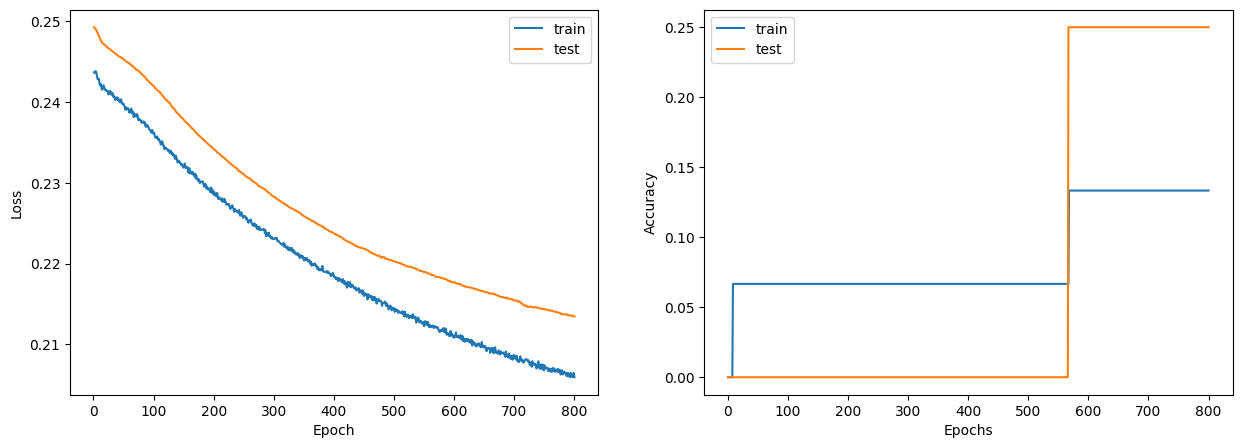

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history.train["epoch"], history.train["loss"], label="train")
axs[0].plot(history.test["epoch"], history.test["loss"], label="test")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(history.train["epoch"], history.train["accuracy"], label="train")
axs[1].plot(history.test["epoch"], history.test["accuracy"], label="test")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

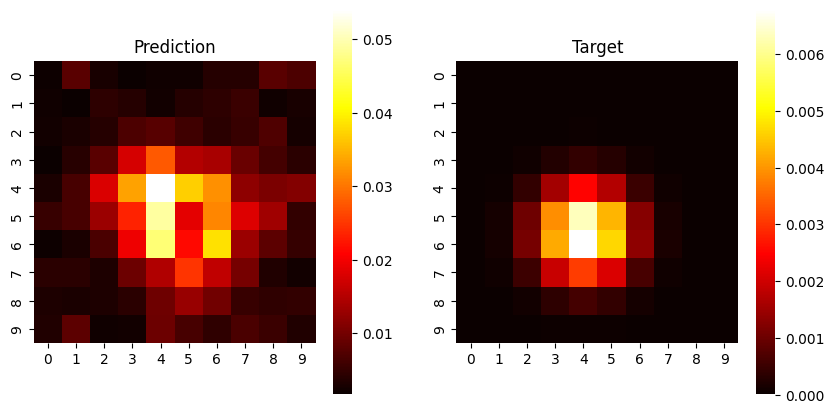

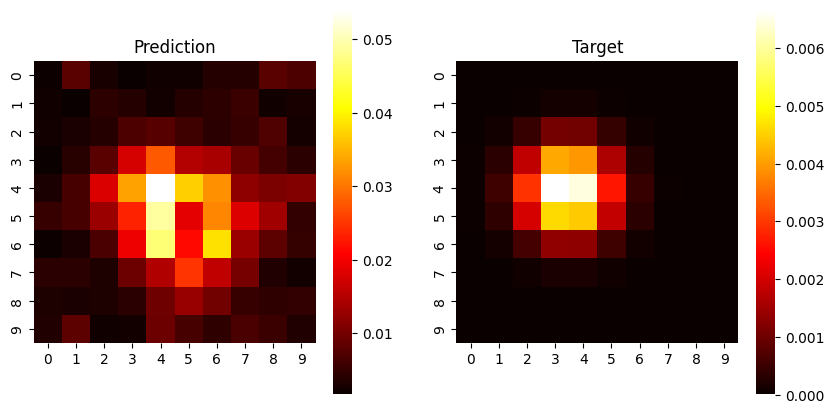

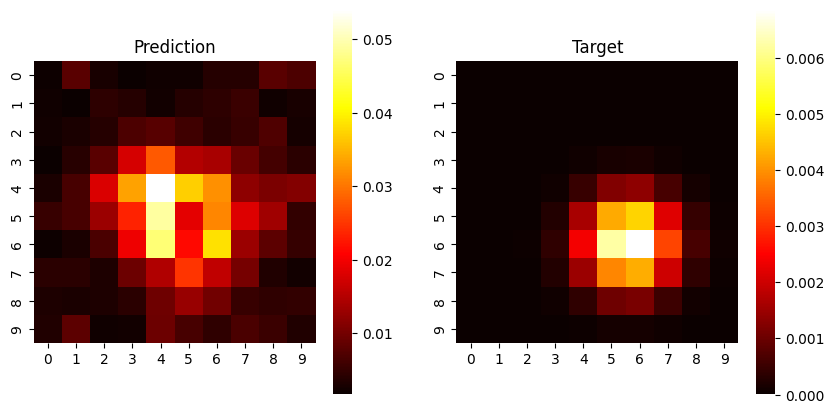

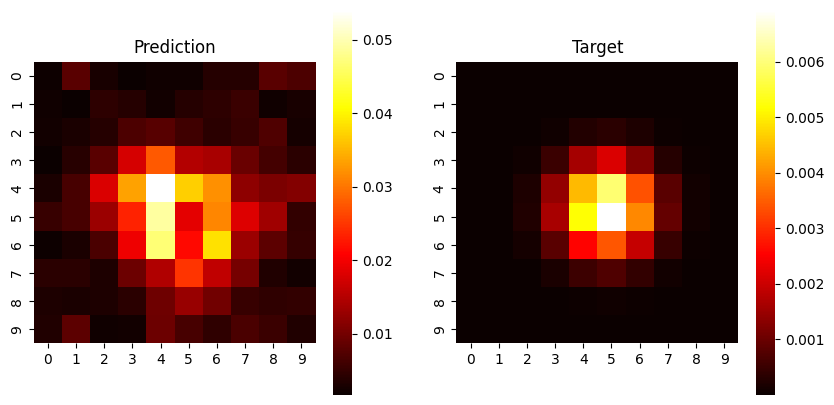

In [ ]:
def render_target_and_prediction(sample_idx = 0):
    sample, target = ds_train[sample_idx]
    prediction = softmax(model(sample).detach(), dim=1).view(*GRID_SIZE[::-1])
    target = target.view(*GRID_SIZE[::-1])
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    sns.heatmap(prediction, cmap="hot", square=True, ax=axs[0])
    axs[0].set_title("Prediction")

    sns.heatmap(target, cmap="hot", square=True, ax=axs[1])
    axs[1].set_title("Target")

for i in range(4):
    render_target_and_prediction(sample_idx=i)

<Axes: >

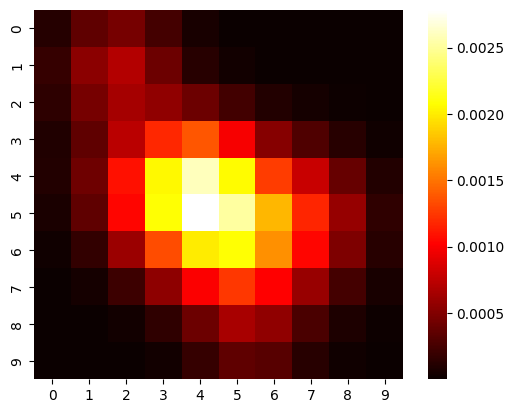

In [ ]:
_, labels = ds[:]
mean_label = labels.mean(dim=0)
sns.heatmap(mean_label.view(GRID_SIZE), square=True, cmap="hot")

In [ ]:
hw_design = model.hardware_model.create_design("ball_throw")

path = OnDiskPath("build")

channels, signal_length = ds_train[0][0].shape
total_length = channels * signal_length
firmware = FirmwareENv5(hw_design, x_num_values=total_length,
                        y_num_values=GRID_SIZE[0]*GRID_SIZE[1], skeleton_version="v2", id=666)

firmware.save_to(path)